In [1]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch 
import random
import os
from sklearn.model_selection import train_test_split
from IPython.display import HTML

import matplotlib.pyplot as plt


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(2023)


def parquet_to_fasta(parquet_file_path, fasta_file_path):
    # Read the parquet file using Polars
    df = pl.read_parquet(parquet_file_path)
    
    # Check if the required columns are present in the DataFrame


    # Convert to Pandas DataFrame
    df_pandas = df.to_pandas().drop_duplicates(subset=['sequence_id'])
    
    # Open a file to write the FASTA format
    with open(fasta_file_path, 'w') as fasta_file:
        # Iterate through each row in the Pandas DataFrame
        for _, row in tqdm(df_pandas.iterrows()):
            sequence_id = row['sequence_id']
            sequence = row['sequence']
            sequence = sequence[26:-21]
            fasta_file.write(f">{sequence_id}\n{sequence}\n")


            

#code to convert output to pandas dataframe
# Initialize an empty list to collect rows
def read_clstr(fn = "similar_to_test.clstr"):
    rows = []

    # Read the cluster file
    with open(fn, "r") as f:
        current_cluster = None
        for line in f:
            if line.startswith(">Cluster"):
                current_cluster = int(line.split()[-1])
            else:
                # Parse the sequence line
                parts = line.strip().split("\t")
                index = int(parts[0])
                length = int(parts[1].split("nt,")[0])
                seq_id = parts[1].split(">")[-1].split("...")[0]
                is_rep = "*" in line
                identity = float(parts[-1].split("/")[-1].rstrip("%")) if "at" in line else 100.0

                # Append this as a row
                rows.append({
                    "cluster": current_cluster,
                    "index": index,
                    "length": length,
                    "sequence_id": seq_id,
                    "is_Representative": is_rep,
                    "identity_To_Rep": identity
                })
    return pd.DataFrame(rows)

# Convert to a DataFrame

def read_fasta_ids(filename):
    seq_ids = set()
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('>'):
                # Extract the sequence ID from the line; adjust the parsing based on your specific ID format
                seq_id = line.split()[0].lstrip('>')
                seq_ids.add(seq_id)
    return seq_ids

def filter_clusters(group):
    return ('Train' in group['source'].values) and ('Test' in group['source'].values) and len(group) > 1

In [2]:
#read the clusterd file 
df = read_clstr('clustered_train.clstr')
df.shape

(806573, 6)

In [3]:
print(f"unique_number_of_clusters: {df['cluster'].value_counts()[df['cluster'].value_counts() > 1].shape}")

unique_number_of_clusters: (93029,)


In [4]:
clusters = df.query('identity_To_Rep>95')['cluster'].unique()

In [5]:
df_seq = pd.read_parquet('train_ss_vienna_rna.parquet')[['sequence_id', 'sequence']]

In [6]:
df = pd.merge(df, df_seq, on='sequence_id')

In [18]:
def highlight_differences_html_wrapped(seq1, seq2, line_length=40):
    if len(seq1) != len(seq2):
        return "The sequences are not of the same length."

    highlighted = ""
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            highlighted += f"<span style='color:red;'>{seq2[i]}</span>"
        else:
            highlighted += f"<span style='color:green;'>{seq2[i]}</span>"

        # Add a line break every 'line_length' characters
        if (i + 1) % line_length == 0:
            highlighted += "<br>"

    return HTML(highlighted)

def highlight_common_places_html(sequences, line_length=40):
    if not sequences:
        return "No sequences provided."

    # Check if all sequences are of the same length
    seq_length = len(sequences[0])
    if not all(len(seq) == seq_length for seq in sequences):
        return "Sequences are not of the same length."

    highlighted = ""
    for i in range(seq_length):
        # Check if the character at position i is the same across all sequences
        if all(seq[i] == sequences[0][i] for seq in sequences):
            # If yes, color it green
            highlighted += f"<span style='color:green;'>{sequences[0][i]}</span>"
        else:
            # If not, leave it as default (black)
            highlighted += sequences[0][i]

        # Add a line break every 'line_length' characters
        if (i + 1) % line_length == 0:
            highlighted += "<br>"

    return HTML(highlighted)


class RnaDataset():
    def __init__(
        self,
        df
    ):
        """
        short sequence without adapters
        """
        self.seq_map = {"A": 0, "C": 1, "G": 2, "U": 3}
        self.Lmax = 206
        df["L"] = df.sequence.apply(len)
        df_2A3 = df.loc[df.experiment_type == "2A3_MaP"].reset_index(drop=True)
        df_DMS = df.loc[df.experiment_type == "DMS_MaP"].reset_index(drop=True)
        

        self.L = df_2A3["L"].values
        self.seq = df_2A3["sequence"].values
        self.react_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_0" in c]
        ].values
        self.react_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_0" in c]
        ].values
        self.react_err_2A3 = df_2A3[
            [c for c in df_2A3.columns if "reactivity_error_0" in c]
        ].values
        self.react_err_DMS = df_DMS[
            [c for c in df_DMS.columns if "reactivity_error_0" in c]
        ].values
        self.sn_2A3 = df_2A3["signal_to_noise"].values
        self.sn_DMS = df_DMS["signal_to_noise"].values
        self.df_2A3 = df_2A3

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, seq_id):
        idx = self.df_2A3.query('sequence_id == @seq_id').index[0]
        seq = self.seq[idx]

        react = torch.from_numpy(
            np.stack([self.react_2A3[idx], self.react_DMS[idx]], -1)
        )[:, :len(seq)]
        react_err = torch.from_numpy(
            np.stack([self.react_err_2A3[idx], self.react_err_DMS[idx]], -1)
        )[:, :len(seq)]


        return {"react": react, "react_err": react_err}
    
    
def sort_sequences_by_all_mutations_with_ids(sequences):
    """
    Sort sequences based on all mutation positions from the first sequence and return their indices.
    Assumes all sequences are of the same length.
    """
    def mutation_positions(seq, reference):
        positions = []
        for i in range(len(seq)):
            if seq[i] != reference[i]:
                positions.append(i)
        return positions if positions else [float('inf')]  # Return a high number if no mutations

    reference_sequence = sequences[0]
    sorted_indices = sorted(range(len(sequences)), key=lambda i: mutation_positions(sequences[i], reference_sequence))

    return sorted_indices

ds = RnaDataset(pd.read_parquet('../data/train_corrected.parquet'))


In [19]:
!ls ../data/

Ribonanza_bpp_files	  split
all_test_data.npy	  supplementary_silico_predictions
eterna_openknot_metadata  test_sequences.csv
rcentral.parquet	  train_corrected.parquet
rmdb_data.v1.3.0.csv	  train_data.csv
sample_submission.csv	  train_data.parquet
sequence_libraries


In [45]:
th = 95

cluster_id = 0
df_ = df.query("identity_To_Rep>@th").query('cluster==@clusters[@cluster_id]')
ids =sort_sequences_by_all_mutations_with_ids(df_['sequence'].to_list())
df_ = df_.iloc[ids].reset_index(drop = True)

print(df_.shape, cluster_id)

(14, 7) 0


In [46]:
df_

,cluster,index,length,sequence_id,is_Representative,identity_To_Rep,sequence
0,0,781,159,633cf50c7ef0,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGACCAUCGUGUCUCAAGUG...
1,0,270,159,ddd255e3df7d,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGAGUCUCAAGUG...
2,0,58,159,8bcbfb1a9a14,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
3,0,212,159,a703e3d1b37a,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
4,0,158,159,c28024e41cd3,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
5,0,594,159,9d1ca11bb4a1,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
6,0,506,159,b64a66c5df60,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
7,0,810,159,8b50908d1a77,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
8,0,642,159,ec1b96b11837,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...
9,0,181,159,c3ef07cfb7ef,False,95.60,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCAUCGUGUCUCAAGUG...


In [47]:
highlight_common_places_html(df_['sequence'].to_list())

In [48]:
import seaborn as sbn

In [49]:
ac_2a3 = np.concatenate([np.clip(ds[i]['react'].numpy()[:, 0], 0, 1) for i in df_['sequence_id']]).reshape(df_.shape[0], -1)
ac_dm = np.concatenate([np.clip(ds[i]['react'].numpy()[:, 1], 0, 1) for i in df_['sequence_id']]).reshape(df_.shape[0], -1)

In [52]:
fig = plt.figure()
font_size=6
plt.subplot(121)
plt.title(f'reactivity_DMS_MaP', fontsize=font_size)
plt.imshow(ac_dm,vmin=0,vmax=1, cmap='gray_r')
plt.subplot(122)
plt.title(f'reactivity_2A3_MaP', fontsize=font_size)
plt.imshow(ac_2a3,vmin=0,vmax=1, cmap='gray_r')
plt.tight_layout()
plt.savefig(f"plot.png",dpi=500)
plt.clf()
plt.close()


<Axes: >

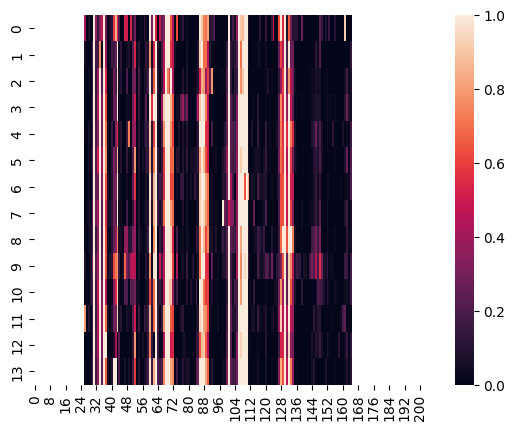

In [51]:
sbn.heatmap(ac_2a3)

In [50]:
ac_2a3.shape

(14, 206)